### Importing our own functions

In [1]:
import importlib

import src.Data as Data
importlib.reload(Data)
Data = Data.Data

import src.Metrics as Metrics
importlib.reload(Metrics)
Metrics = Metrics.Metrics

### Importing libraries
`numpy` and `pandas` are used to manipulate the data

`scikit-learn` is used to train the classification models and compute the metrics

`matplotlib` and `seaborn` are used to plot the results

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import LearningCurveDisplay, learning_curve, cross_validate, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

### Choosing the models
Here you can choose which models you want include in the analysis.

The parameter `n_jobs` is used to specify the number of cores to use for parallel processing. If `-1` is given, all cores are used.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

classifiers = [
    DecisionTreeClassifier(), 
    RandomForestClassifier(n_jobs=-1), 
    BaggingClassifier(n_jobs=-1), 
    LogisticRegression(n_jobs=-1), 
    # SVC(), 
    # GaussianNB(), 
    # SGDClassifier(n_jobs=-1), 
    # KNeighborsClassifier(n_jobs=-1), 
    # GradientBoostingClassifier(), 
    # MLPClassifier(), 
    # AdaBoostClassifier()
]

### Loading the data
The data is loaded from the `data` folder.

Samples are split into a training set and a test set with a custom ratio. Stratified sampling is used to ensure that the proportion of samples in each class is the same in both sets.

The number of samples in the least represented class is computed to choose the number of folds for cross-validation.

In [4]:
data: Data = Data(test_size=0.2)

least_populated_class_count = np.unique(data.y_train, return_counts=True)[1].min()
print("Least populated class count:", least_populated_class_count)
print("This is the maximum valid number of folds for cross validation.")

Least populated class count: 8
This is the maximum valid number of folds for cross validation.


### Training the models

#### _Without cross-validation_
We first train the models on the training set without cross-validation.

Several metrics are computed on the test set to evaluate the performance of the models and are then plotted.

Fit the model without cross-validation or hyperparameter tuning. 



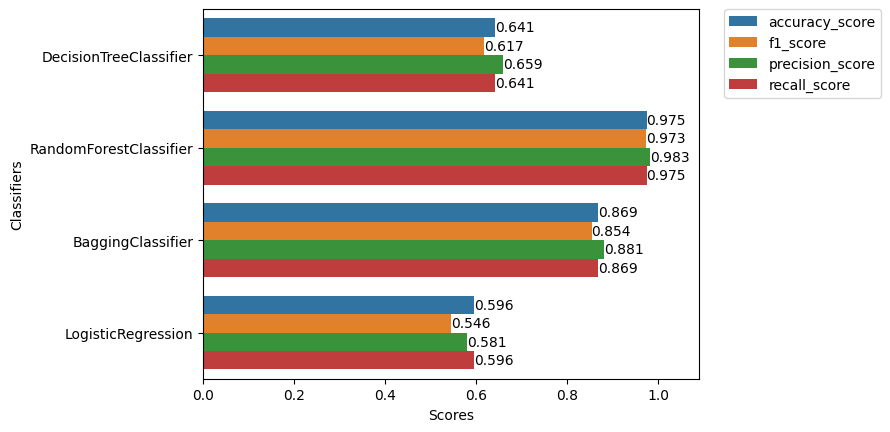

In [5]:
print('Fit the model without cross-validation or hyperparameter tuning. \n')

metrics_list = []

for classifier in classifiers:
    classifier.fit(data.x_train, data.y_train)
    predictions = classifier.predict(data.x_test)

    classifier_metrics = Metrics(classifier_name=classifier.__class__.__name__)
    # Computing metrics
    classifier_metrics.add_metric('accuracy_score', accuracy_score(data.y_test, predictions))
    classifier_metrics.add_metric('f1_score', f1_score(data.y_test, predictions, average='macro'))
    classifier_metrics.add_metric('precision_score', precision_score(data.y_test, predictions, average='macro'))
    classifier_metrics.add_metric('recall_score', recall_score(data.y_test, predictions, average='macro'))

    metrics_list.append(classifier_metrics)

Metrics.show_metrics_list(metrics_list)

#### _With cross-validation_
We then train the models on the training set with cross-validation.

The number of folds is chosen to be the number of samples in the least represented class to ensure that each fold contains at least one sample of each class. (This is automatically done by `sklearn.model_selection.StratifiedKFold` used by the function `cross_validate`.)

Fit the model with cross-validation.



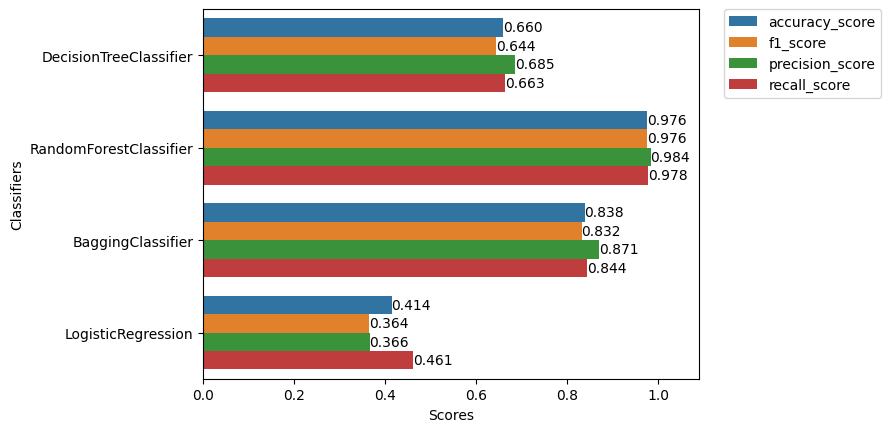

In [8]:
print('Fit the model with cross-validation.\n')

metrics_list_cv = []

for classifier in classifiers:
    scores = cross_validate(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    classifier_metrics = Metrics(classifier_name=classifier.__class__.__name__)
    # Storing metrics
    classifier_metrics.add_metric('accuracy_score', scores['test_accuracy'].mean())
    classifier_metrics.add_metric('f1_score', scores['test_f1_macro'].mean())
    classifier_metrics.add_metric('precision_score', scores['test_precision_macro'].mean())
    classifier_metrics.add_metric('recall_score', scores['test_recall_macro'].mean())

    metrics_list_cv.append(classifier_metrics)

Metrics.show_metrics_list(metrics_list_cv)


#### _Plotting metrics for each fold_
We plot the metrics for each fold to see if there is a significant difference between the folds.

The printed values are the mean for each metric over all folds.

Classifier : DecisionTreeClassifier
	Mean train accuracy : 1.0
	Mean test accuracy : 0.6878196302124311
	Mean train precision : 1.0
	Mean test precision : 0.6329755892255893
	Mean train recall : 1.0
	Mean test recall : 0.6893939393939393
	Mean train f1 : 1.0
	Mean test f1 : 0.6369708994708995


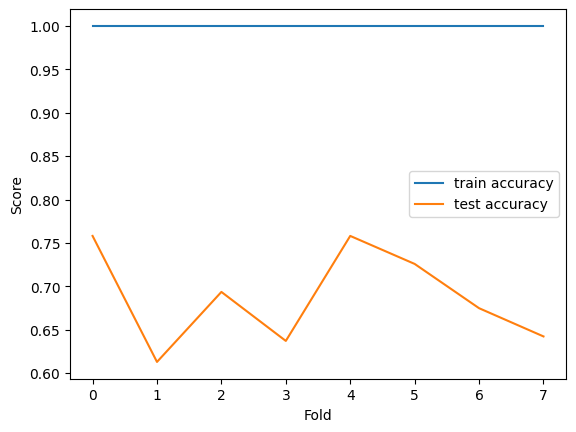



Classifier : RandomForestClassifier
	Mean train accuracy : 1.0
	Mean test accuracy : 0.9767899291896145
	Mean train precision : 1.0
	Mean test precision : 0.9741161616161615
	Mean train recall : 1.0
	Mean test recall : 0.9797979797979798
	Mean train f1 : 1.0
	Mean test f1 : 0.973989898989899


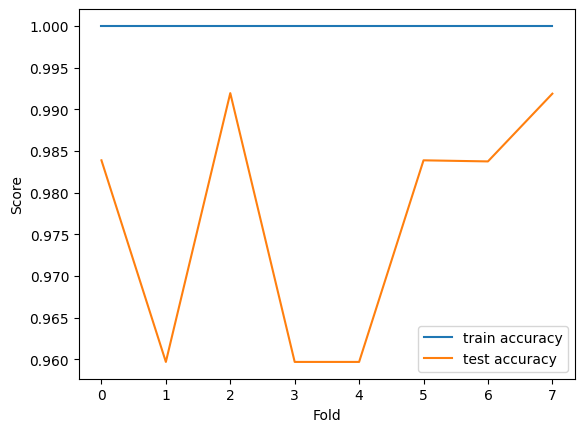



Classifier : BaggingClassifier
	Mean train accuracy : 0.9994226327944573
	Mean test accuracy : 0.8656733543141883
	Mean train precision : 0.9994668911335578
	Mean test precision : 0.8217592592592593
	Mean train recall : 0.9994212962962963
	Mean test recall : 0.8667929292929293
	Mean train f1 : 0.9994115562227017
	Mean test f1 : 0.8291666666666667


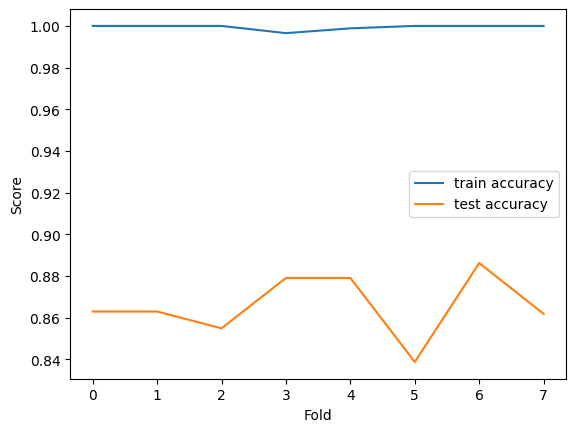



Classifier : LogisticRegression
	Mean train accuracy : 0.6082185591258646
	Mean test accuracy : 0.46776652242328876
	Mean train precision : 0.6326478966097422
	Mean test precision : 0.40377932953690526
	Mean train recall : 0.5978184624017957
	Mean test recall : 0.5315656565656566
	Mean train f1 : 0.5576406466587839
	Mean test f1 : 0.42850356013234797


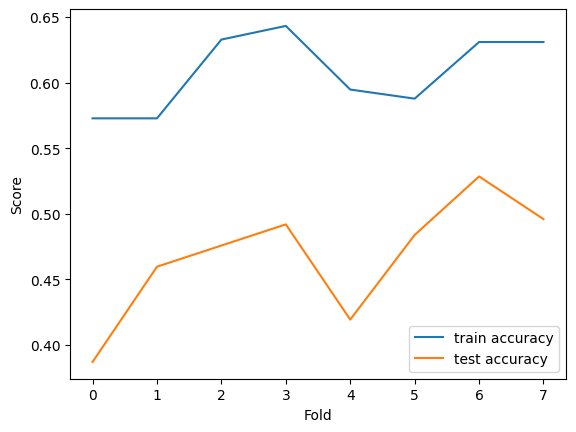

In [9]:

for classifier in classifiers:
    print(f'Classifier : {classifier.__class__.__name__}')

    scores = cross_validate(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Fitting one last time (needed ?)
    # classifier.fit(data.x_train, data.y_train)
    # print(Metrics(classifier, data))

    print(f'\tMean train accuracy : {scores["train_accuracy"].mean()}')
    print(f'\tMean test accuracy : {scores["test_accuracy"].mean()}')
    print(f'\tMean train precision : {scores["train_precision_macro"].mean()}')
    print(f'\tMean test precision : {scores["test_precision_macro"].mean()}')
    print(f'\tMean train recall : {scores["train_recall_macro"].mean()}')
    print(f'\tMean test recall : {scores["test_recall_macro"].mean()}')
    print(f'\tMean train f1 : {scores["train_f1_macro"].mean()}')
    print(f'\tMean test f1 : {scores["test_f1_macro"].mean()}')
    
    # Plotting the metrics for each fold
    plot_cross_validation: bool = True
    if plot_cross_validation:
        # Plot graph of scores
        plt.figure()
        plt.plot(scores['train_accuracy'], label='train accuracy')
        plt.plot(scores['test_accuracy'], label='test accuracy')
        # plt.plot(scores['train_precision_macro'], label='train precision')
        # plt.plot(scores['test_precision_macro'], label='test precision')
        # plt.plot(scores['train_recall_macro'], label='train recall')
        # plt.plot(scores['test_recall_macro'], label='test recall')
        # plt.plot(scores['train_f1_macro'], label='train f1')
        # plt.plot(scores['test_f1_macro'], label='test f1')
        plt.xlabel('Fold')
        plt.ylabel('Score')
        plt.legend()
        plt.show()
    
    print('\n')

#### _Plotting metrics for each size of training set_
To study the influence of the size of the training set on the performance of the models, we plot the accuracy for several sizes of training set.

Fit model with cross-validation for different training set sizes.

Classifier : DecisionTreeClassifier
	Mean train score : 1.0
	Mean test score : 0.45721544715447154


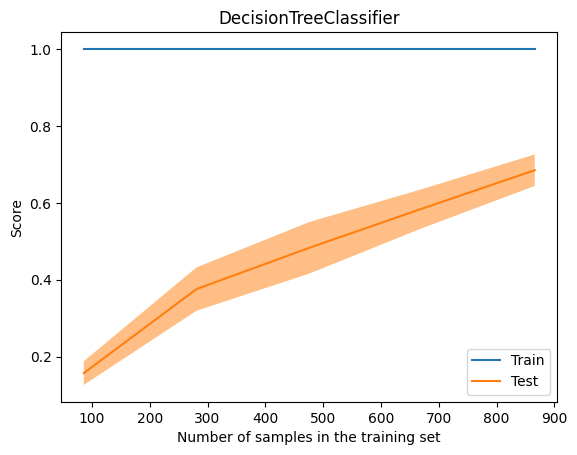

Classifier : RandomForestClassifier
	Mean train score : 1.0
	Mean test score : 0.8145767768161554


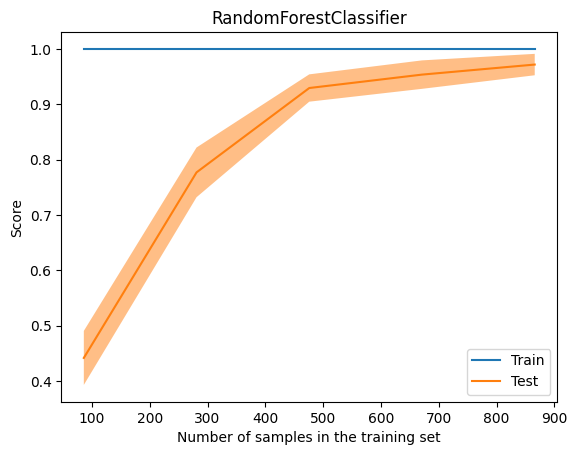

Classifier : BaggingClassifier
	Mean train score : 0.9962197729555454
	Mean test score : 0.6137359034880671


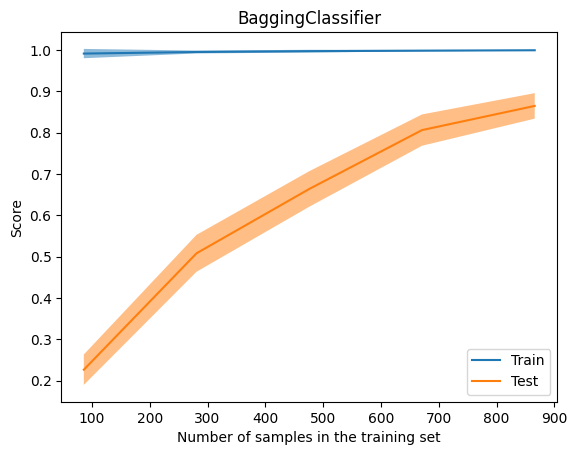

Classifier : LogisticRegression
	Mean train score : 0.2665445429581396
	Mean test score : 0.17744230264883293


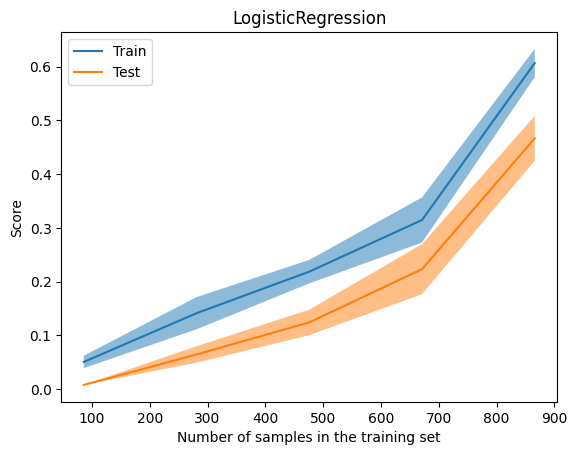

In [7]:
print('Fit model with cross-validation for different training set sizes.\n')

for classifier in classifiers:
    print(f'Classifier : {classifier.__class__.__name__}')
    # Determines cross-validated training and test scores for different training set sizes.
    # [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)
    #   cv -> cv-fold cross-validation.
    #   n_jobs -> number of jobs to run in parallel : -1 means using all processors.
    #   No need to shuffle the data because it has already been shuffled (within Data class).
    train_sizes_abs, train_scores, test_scores = learning_curve(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, )
    
    classifier.fit(data.x_train, data.y_train)
    print(f'\tMean train score : {train_scores.mean()}')
    print(f'\tMean test score : {test_scores.mean()}')
    
    plot_learning_curve: bool = True
    if plot_learning_curve:
        display = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_scores, test_scores=test_scores, score_name="Score")
        display.plot()
        display.ax_.set_title(classifier.__class__.__name__)
        plt.show()
    
    # for train_size, cv_train_scores, cv_test_scores in zip(train_sizes_abs, train_scores, test_scores):
    #     print(f"{train_size} samples were used to train the model")
    #     print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    #     print(f"The average test accuracy is {cv_test_scores.mean():.2f}")